#### 机器学习实战（基于Sklearn和tensorflow）第二章学习笔记

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original',data_home='./datasets')

/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/envs/kerasGPU/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


fetch_mldata下载较慢，可以下载到本地
链接：https://pan.baidu.com/s/1fAInuofJ_MJJfvNjY1djsg 
提取码：e462 
在当前工程目录下新建并拷贝自己下载文件 
datasets/mldata/mnist-original.mat
其实从fetch_mldata源码里看到 是从这个目录下加载。
```python
data_home = join(data_home, 'mldata')
    if not exists(data_home):
        os.makedirs(data_home)

    matlab_name = dataname + '.mat'
    filename = join(data_home, matlab_name)
    ```

In [2]:
X, y = mnist["data"], mnist["target"]

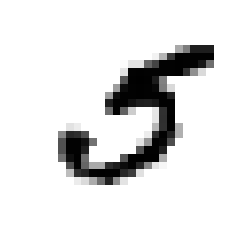

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.get_cmap("binary"), interpolation="nearest")
plt.axis("off")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
#打乱数据
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

##### 训练一个二分类器

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=None)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
sgd_clf.predict([some_digit])

array([False])

#### 性能考核
##### 使用交叉验证测量精度
自定义分组
分成3组 每次取一组作为验证 总共三个输出
```python
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pre = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pre == y_test_fold)
    print(n_correct / len(y_pre))
    ```

In [8]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9409 , 0.95175, 0.9576 ])

Never5Classifier这里返回全false 判断输入是非5 也就是输入任何数据准确率都可以达到90%

In [9]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9088 , 0.91085, 0.9093 ])

##### 混淆矩阵 精度 召回率
|  数量| 预测成负样本 | 预测成正样本 |
| ------ | ------ | ------ |
| 实际是负样本 | 52509 TN true negatives | 2070 FP false positives|
| 实际是正样本 | 1118 FN false negatives | 4303 TP true positives |

52509表示负样本预测对了 2070表示应该是负样本，但是却预测成正样本了
1118 实际是正样本，但是预测成负样本了  4303预测正样本成功
一个完美的分类器得到混淆矩阵应该是反对角线为0：

|  数量| 预测成负样本 | 预测成正样本 |
| ------ | ------ | ------ |
| 实际是负样本 | yyyyy | 0 |
| 实际是正样本 | 0 | xxxx |

**分类器精度** $\frac{TP}{TP+FP}$ 即$\frac{4303}{4303 + 2070}$
而上一步精度是$\frac{52509+4303}{60000} = 0.947$

**召回率 （灵敏度或真正类TPR）**
$\frac{TP}{TP+FN}$

**组合召回率和精度F1**
$\frac {2}{\frac {1}{精度} + \frac {1}{召回率}}$


In [10]:
#cross_val_predict 返回单个样本分类
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53642,   937],
       [ 2058,  3363]])

In [11]:
#精度 召回率 F1分数
from sklearn.metrics import precision_score, recall_score
print("precision : ", precision_score(y_train_5, y_train_pred), " recall : ", recall_score(y_train_5, y_train_pred))
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

precision :  0.782093023255814  recall :  0.6203652462645268


0.6919041250900113

##### 精度/召回率权衡
cross_val_predict 获取所有训练样本分数
通过该阈值来计算所有可能阈值对应的精度和召回率

In [12]:
#查看样例分数
y_scores = sgd_clf.decision_function([some_digit])
#获取模型样例的分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

通过观察曲线可以得到精度和召回率变化大致趋势相反
实际场景可根据曲线取得合适的值

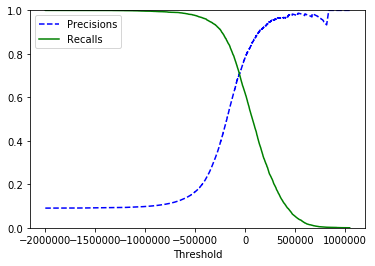

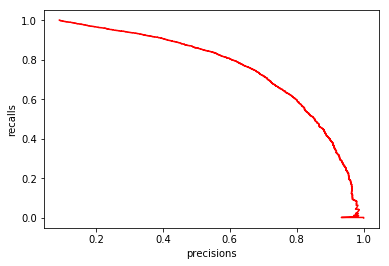

In [13]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisions")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recalls")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
plt.plot(precisions[:-1], recalls[:-1], 'r')
plt.xlabel("precisions")
plt.ylabel("recalls")
plt.show()

因为随机梯度下降分类器使用的阈值是0 
这里使用70000 可以看到准确率提升了

In [14]:
y_train_pred_90 = (y_scores > 70000)
# 之前阈值为0时候 precision :  0.6751922171661697  recall :  0.7937649880095923
print("precision : ", precision_score(y_train_5, y_train_pred_90), " recall : ", recall_score(y_train_5, y_train_pred_90))

precision :  0.8509645301804605  recall :  0.5045194613539937


##### ROC曲线
ROC曲线描述的是召回率和假正类率FPR的关系
FPR=1-TNR  也就是实际负类集合中被识别成正类的比例
FPR=$\frac {FP}{FP+TN}$
TNR=$\frac {TN}{FP+TN}$
一个完美分类器ROC 曲线下面积AUC应该是1

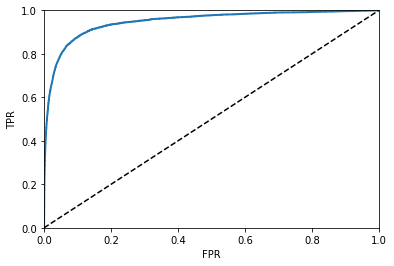

0.9483454270962471

In [15]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
plot_roc_curve(fpr, tpr)
plt.show()
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

训练一个随机森林分类器，对比随机梯度下降分类器

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

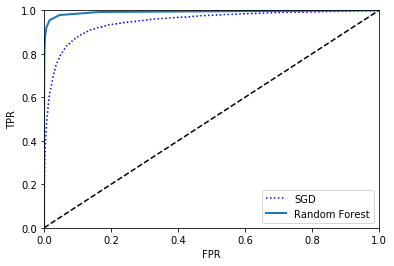

In [17]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="best")
plt.show()

##### 多类别分类器
- 一对多OvA例如一个系统将数字图片分为10个类别 那么就有10个分类器
- 二元分类器OvO 例如一个区分0和1 0和2 1和2 如果存在N个分类共需要N*(N-1)/2 优点每个分类器只需要部分训练对需要区分的类别进行区分
sklearn默认用OvA (svm例外 默认使用OvO)

In [18]:
sgd_clf.fit(X_train, y_train)
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-103422.61322446, -525503.94353144, -442518.23219181,
         -26029.25730913, -465852.91594418, -108573.28960449,
        -643508.00417206, -345911.58285036, -666398.35048583,
        -389111.35452409]])

In [19]:
np.argmax(some_digit_scores)
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [20]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=5, tol=None))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [21]:
len(ovo_clf.estimators_)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87787443, 0.86124306, 0.87318098])

In [22]:
#进行缩放之后调整模型准确率 去均值和方差归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90696861, 0.91034552, 0.91213682])

##### 错误分析
判断10个分类数据的混淆矩阵
由下图对角线可以看出绝大部分分类都是正确的

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    3,   22,    9,   12,   48,   45,    7,   40,    3],
       [   1, 6468,   47,   26,    6,   47,    5,    8,  121,   13],
       [  58,   32, 5339,  103,   77,   24,   90,   59,  163,   13],
       [  45,   42,  139, 5351,    4,  230,   37,   52,  135,   96],
       [  18,   28,   39,   10, 5371,   11,   54,   30,   78,  203],
       [  81,   43,   33,  181,   73, 4595,  108,   26,  187,   94],
       [  32,   26,   48,    2,   40,   88, 5632,    5,   44,    1],
       [  27,   21,   75,   31,   56,   11,    3, 5775,   17,  249],
       [  49,  155,   64,  156,   13,  151,   62,   27, 5035,  139],
       [  44,   31,   27,   84,  162,   36,    2,  186,   88, 5289]])

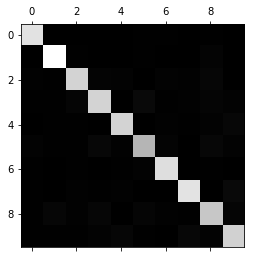

In [24]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

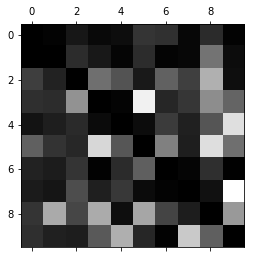

In [25]:
#更加突出识别错误的标签
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

##### 多标签分类
输入一个样本，输出多个纬度的分类结果
例子是分类标签是是否大于7和是否是奇数

In [26]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train > 7)
y_train_odd = (y_train % 2 == 1)
#
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

**f1_score**
'macro': 对每一类别的f1_score进行简单算术平均
'weighted': 对每一类别的f1_score进行加权平均，权重为各类别数在y_true中所占比例。
'micro': 设置average='micro'时，Precision = Recall = F1_score = Accuracy。
None：返回每一类各自的f1_score，得到一个array。
'binary':  只对二分类问题有效，返回由pos_label指定的类的f1_score。

In [27]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)#运行时间较长
f1_score(y_train, y_train_knn_pred, average="macro")

0.9685597660766623

In [28]:
f1_score(y_train, y_train_knn_pred, average="weighted")

0.9686812726787276

##### 多输出分类
多输出-多类别
例子：对原始图片增加噪点 增加噪点前数据杨输入X 标签是原始数据

In [50]:
# X_train_split = X_train[0:10000]
# X_test_split = X_test[0:10000]
# print(len(X_train_split))
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))

X_tran_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

In [51]:
knn_clf.fit(X_tran_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[2]])

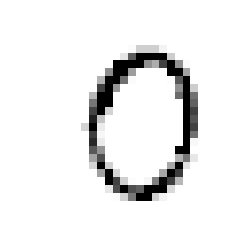

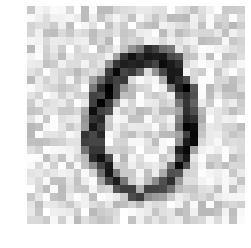

In [52]:
some_digit_image = clean_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.get_cmap("binary"), interpolation="nearest")
plt.axis("off")
plt.show()
some_digit_image = X_test_mod[2].reshape(28, 28)
plt.imshow(some_digit_image, cmap=plt.get_cmap("binary"), interpolation="nearest")
plt.axis("off")
plt.show()